In [16]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import clear_output
from random import sample

from simcube.pipeline import init_random_seed, copy_data_to_device

plt.rcParams["figure.figsize"] = (15,10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('../../data/raw/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

In [3]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [4]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [5]:
len(quotes)

36165

In [6]:
max(map(len, quotes))

409

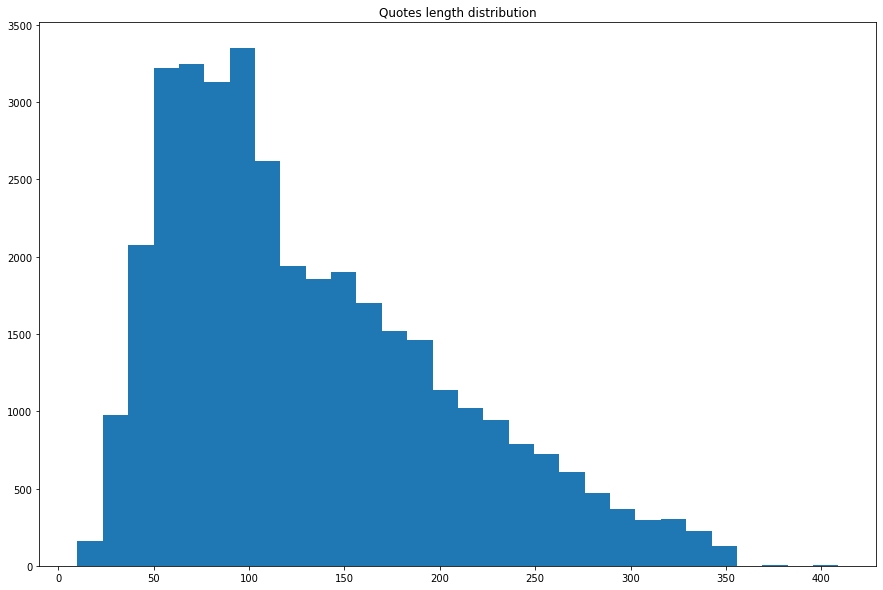

In [8]:
plt.title('Quotes length distribution')
plt.hist(list(map(len, quotes)), bins=30);

In [9]:
#all unique characters go here
tokens = list(set(''.join(quotes)))

num_tokens = len(tokens)
print ('num_tokens:', num_tokens)

num_tokens: 85


In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [12]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[char] for char in data[i]]
        data_ix[i, :len(line_ix[:max_len])] = line_ix[:max_len]
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [14]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(quotes[::2000]))
print(to_matrix(quotes[::2000], token_to_id))

 If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.
 In the beginning, everybody that gets to work with me, thinks I'm nice. But three weeks later, they hear a bell ringing. Then they realise I meant everything I said during that first week. It's not my fault people are not taking me serious from the first moment.
 I tend to get comfortable with the dialogue and find out who the person is in the script and try to hit that. People are sort of independent of their occupations and their pastimes. You don't play a politician or a fireman or a cowboy - you just play a person.
 'Tis love that makes the world go round, my baby.
 Some of these kids just don't plain know how good they are: how smart and how much they have to say. You can tell them. You can shine that light on them, one human interaction at a time.
 I was able to realize that I definitely want to make sure that I use my voice, as it gets bigger and bigger, in the world 

In [53]:
from torch import Tensor
from typing import Tuple

In [54]:
MAX_LENGTH = 350
BATCH_SIZE = 1024

In [55]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [56]:
init_random_seed(42)

In [64]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64, dropout=0.3):
        super(self.__class__, self).__init__()
        self.embedding = nn.Embedding(num_tokens, emb_size)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, src: Tensor) -> Tuple[Tensor]:
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        next_logits = self.fc(hidden)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [66]:
device = torch.device(device)

In [67]:
model = CharRNNLoop(emb_size=32)
opt = torch.optim.Adam(model.parameters())
history = []

In [68]:
model.to(device)

CharRNNLoop(
  (embedding): Embedding(85, 32)
  (dropout): Dropout(p=0.3, inplace=False)
  (rnn): RNN(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=85, bias=True)
)

In [69]:
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 14517


In [74]:
%%time

for i in range(500):
    batch_ix = to_matrix(sample(quotes, BATCH_SIZE), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    batch_ix = copy_data_to_device(batch_ix, device)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
        
    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
#     # train with backprop
#     loss.backward()
#     opt.step()
#     opt.zero_grad()
    
#     history.append(loss.data.cpu().numpy())
#     if (i + 1) % 100 == 0:
#         clear_output(True)
#         plt.plot(history, label='loss')
#         plt.legend()
#         plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

RuntimeError: invalid argument 2: Input tensor must have same size as output tensor apart from the specified dimension at /pytorch/aten/src/THC/generic/THCTensorScatterGather.cu:27

In [36]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [37]:
for _ in range(10):
    print(generate_sample(model))

UnboundLocalError: local variable 'hid_state' referenced before assignment

In [44]:
x_sequence = torch.tensor([], dtype=torch.int64)

In [49]:
temperature = 0.2

In [46]:
x_sequence[:]

tensor([], dtype=torch.int64)

In [48]:


for _ in range(MAX_LENGTH):
    logp_next = model(x_sequence)
    p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

    # sample next token and push it back into x_sequence
    next_ix = np.random.choice(len(tokens), p=p_next)
    next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
    x_sequence = torch.cat([x_sequence, next_ix], dim=1)

print(''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]]))

RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_index_select